In [ ]:
%%capture
# BERTopic + llama-cpp-python
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python
!pip install bertopic datasets

# DataMapPlot
!git clone https://github.com/TutteInstitute/datamapplot.git
!pip install datamapplot/.

# GPU-accelerated HDBSCAN + UMAP
!pip install cudf-cu12 dask-cudf-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cugraph-cu12 --extra-index-url=https://pypi.nvidia.com
!pip install cupy-cuda12x -f https://pip.cupy.dev/aarch64

In [ ]:
from datasets import load_dataset

docs = load_dataset("austin/rheum_abstracts")["train"]["abstract"]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/55046 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13762 [00:00<?, ? examples/s]

In [ ]:
!wget https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf


--2024-04-23 01:32:58--  https://huggingface.co/TheBloke/OpenHermes-2.5-Mistral-7B-GGUF/resolve/main/openhermes-2.5-mistral-7b.Q4_K_M.gguf
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.88, 18.172.134.24, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/65/3b/653b1cc7a4558cd22c0ac02df471105878a080cb5694622ccd566697c574592f/cd58120326971c71c0590f6b7084a0744e287ce9c67275d8b4bf34a5947d950b?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27openhermes-2.5-mistral-7b.Q4_K_M.gguf%3B+filename%3D%22openhermes-2.5-mistral-7b.Q4_K_M.gguf%22%3B&Expires=1714095178&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNDA5NTE3OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzY1LzNiLzY1M2IxY2M3YTQ1NThjZDIyYzBhYzAyZGY0NzExMDU4NzhhMDgwY2I1Njk0NjIyY2NkNTY2Njk3YzU3N

In [ ]:
from llama_cpp import Llama

# Use llama.cpp to load in a Quantized LLM
llm = Llama(model_path="openhermes-2.5-mistral-7b.Q4_K_M.gguf", n_gpu_layers=-1, n_ctx=4096, stop=["Q:", "\n"])

llama_model_loader: loaded meta data with 20 key-value pairs and 291 tensors from openhermes-2.5-mistral-7b.Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = teknium_openhermes-2.5-mistral-7b
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 14336
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:                 l

We pass the LLM to BERTopic with a custom prompt. Let's add `KeyBERTInspired` representations to compare the LLM representations with:

In [ ]:
from bertopic.representation import KeyBERTInspired, LlamaCPP

prompt = """ Q:
I have a topic that contains the following documents:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic of at most 5 words?
A:
"""

representation_model = {
    "KeyBERT": KeyBERTInspired(),
    "LLM": LlamaCPP(llm, prompt=prompt),
}

In [ ]:
from sentence_transformers import SentenceTransformer
from cuml.manifold import UMAP
from cuml.cluster import HDBSCAN
# from umap import UMAP
# from hdbscan import HDBSCAN

# Pre-calculate embeddings
embedding_model = SentenceTransformer("BAAI/bge-small-en")
embeddings = embedding_model.encode(docs, show_progress_bar=True)

# Pre-reduce embeddings for visualization purposes
reduced_embeddings = UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(embeddings)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/90.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1721 [00:00<?, ?it/s]

In [ ]:
# Define sub-models
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=100, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(

  # Sub-models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

# Train model
topics, probs = topic_model.fit_transform(docs, embeddings)

2024-04-23 01:45:33,281 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-23 01:45:35,468 - BERTopic - Dimensionality - Completed ✓
2024-04-23 01:45:35,481 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-23 01:45:37,563 - BERTopic - Cluster - Completed ✓
2024-04-23 01:45:37,594 - BERTopic - Representation - Extracting topics from clusters using representation models.
  0%|          | 0/48 [00:00<?, ?it/s]
llama_print_timings:        load time =     669.27 ms
llama_print_timings:      sample time =       8.80 ms /    16 runs   (    0.55 ms per token,  1817.77 tokens per second)
llama_print_timings: prompt eval time =    2642.00 ms /  2088 tokens (    1.27 ms per token,   790.31 tokens per second)
llama_print_timings:        eval time =     453.62 ms /    15 runs   (   30.24 ms per token,    33.07 tokens per second)
llama_print_timings:       total time =    3204.41 ms /  2103 tokens
  2%|▏         | 1/48 [00:03<02:31,  3.22s/it]L

In [ ]:
# Show topics
topic_model.get_topic_info()

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,22431,-1_the_and_of_in,"[the, and, of, in, with, to, were, patients, w...","[arthritis, rheumatoid, osteoarthritis, synovi...",[Disease Modifying Antirheumatic Drugs (DMARDs...,[Disease expression and outcomes in rheumatoid...
1,0,7109,0_knee_the_and_oa,"[knee, the, and, oa, hip, of, osteoarthritis, ...","[osteoarthritis, knee, knees, arthroplasty, ca...","[Knee Osteoarthritis and Pain \n\n---, , , , ,...",[To examine whether obesity increases the risk...
2,1,4331,1_the_ra_to_of,"[the, ra, to, of, patients, and, in, disease, ...","[adalimumab, infliximab, methotrexate, ra, art...","[""RA Treatment Study"", , , , , , , , , ]",[The goal of the present study was to prospect...
3,2,2180,2_cartilage_chondrocytes_oa_expression,"[cartilage, chondrocytes, oa, expression, in, ...","[chondrocytes, chondrocyte, cartilage, osteoar...","[Cartilage Chondrocyte OA Expression Analysis,...",[Our objective was to investigate whether a la...
4,3,1986,3_fibromyalgia_fm_pain_the,"[fibromyalgia, fm, pain, the, and, of, fms, wi...","[fibromyalgia, pain, patients, chronic, depres...","[Fibromyalgia Impact, Comparison, Prevalence, ...",[Depression is one of the most frequent psychi...
5,4,1735,4_cells_il_synovial_ra,"[cells, il, synovial, ra, expression, in, by, ...","[synoviocytes, rheumatoid, arthritis, cytokine...","[""IL-7/IL-7R expression in RA"", , , , , , , , , ]",[The aim of this study was to quantify the num...
6,5,1552,5_ss_sjögren_pss_syndrome,"[ss, sjögren, pss, syndrome, salivary, patient...","[sjogren, sjögren, autoimmune, ss, salivary, x...","[- Sjögren Syndrome and Salivary Gland Invol, ...",[The aim of this study was to characterize and...
7,6,1223,6_gout_urate_allopurinol_of,"[gout, urate, allopurinol, of, and, the, uric,...","[gout, hyperuricemia, allopurinol, gouty, ckd,...","[""Gout management and research"", , , , , , , ,...","[Traditionally, allopurinol is not initiated d..."
8,7,1066,7_knee_tka_the_uka,"[knee, tka, the, uka, flexion, arthroplasty, t...","[arthroplasty, patellofemoral, osteoarthritis,...",[Knee arthroplasty outcomes and complications....,[The purpose of this study was to compare the ...
9,8,946,8_ra_risk_cardiovascular_patients,"[ra, risk, cardiovascular, patients, with, cvd...","[rheumatoid, atherosclerosis, arthritis, ra, l...",[RA and Cardiovascular Risk\n\nQuestion 2:\n\n...,[Rheumatoid arthritis (RA) is characterized by...


(<Figure size 1200x1200 with 1 Axes>,
 <Axes: title={'left': 'Topics labeled with `Mistral`'}>)

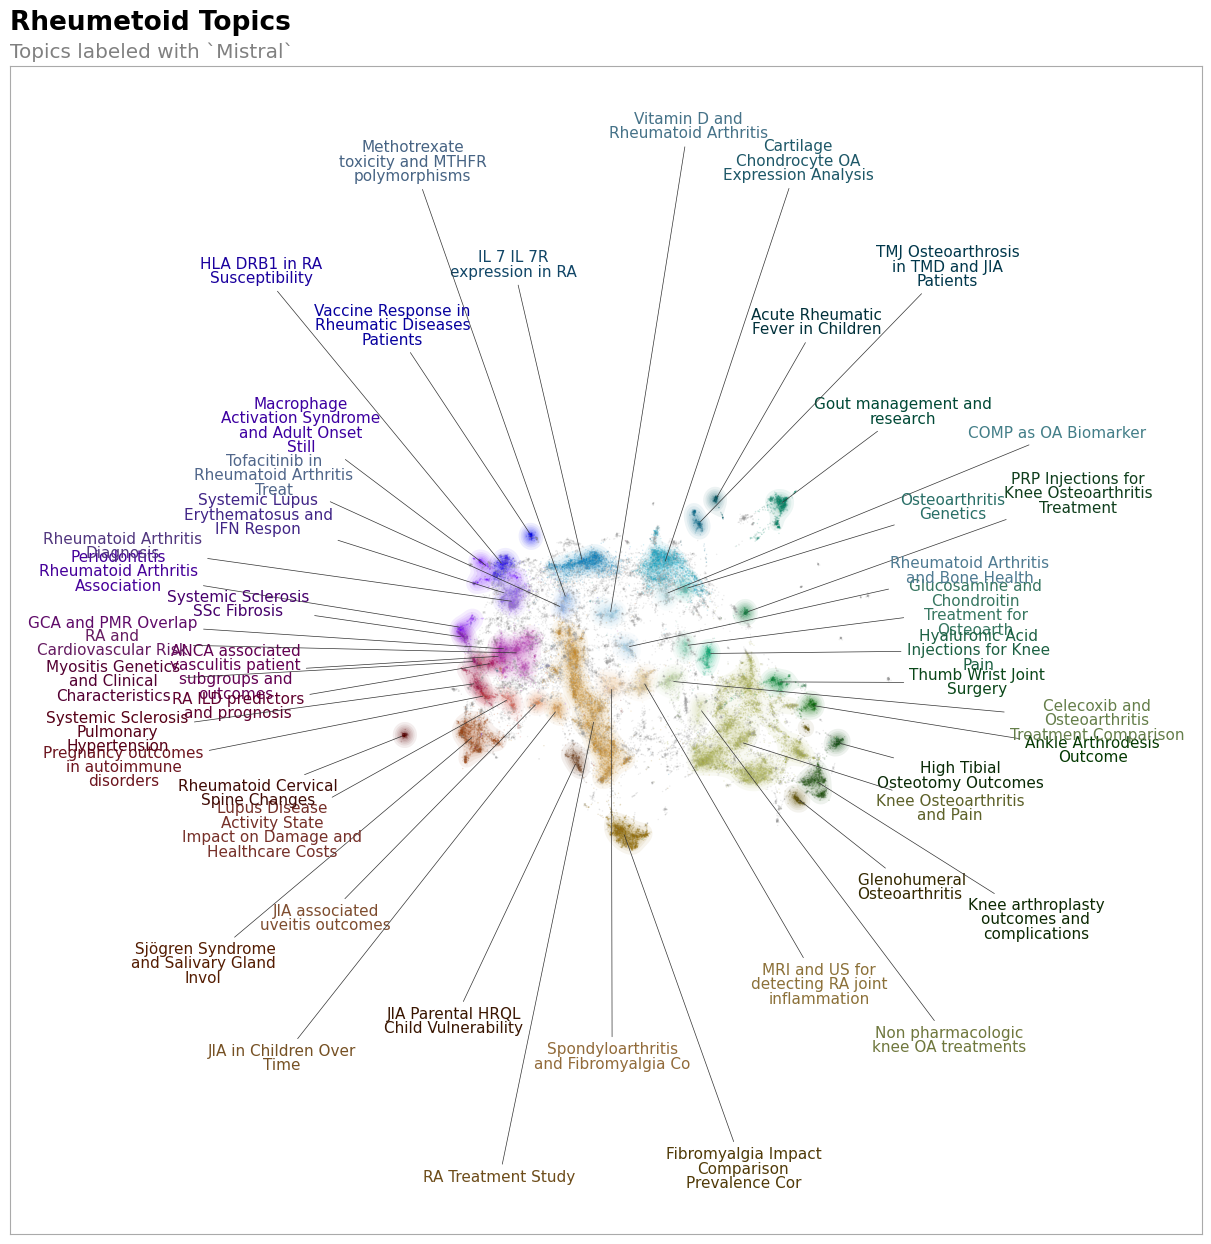

In [ ]:
import datamapplot
import re

# Create a label for each document
llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
llm_labels = [label if label else "Unlabelled" for label in llm_labels]
all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics]

# Run the visualization
datamapplot.create_plot(
    reduced_embeddings,
    all_labels,
    label_font_size=11,
    title="Rheumetoid Topics",
    sub_title="Topics labeled with `Mistral`",
    label_wrap_width=20,
    use_medoids=True,
)